# Ordinary Least Squares (OLS) Regression

In Chapter 2 we introduced linear regression with least absolute deviations (LAD). Here we consider the same problem setting, but slightly change the underlying optimization problem, in particular its objective function, obtaining the classical ordinary least squares (OLS) regression.

In [1]:
# install Pyomo and solvers
import requests
import imp

url = "https://raw.githubusercontent.com/jckantor/MO-book/main/python/helper.py"
helper = imp.new_module("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_glpk()

pyomo was previously installed
glpk was previously installed


True

## Generate data

The Python [scikit learn](https://scikit-learn.org/stable/) library for machine learning provides a full-featured collection of tools for regression. The following cell uses `make_regression` from scikit learn to generate a synthetic data set for use in subsequent cells. The data consists of a numpy array `y` containing `n_samples` of one dependent variable $y$, and an array `X` containing `n_samples` observations of `n_features` independent explanatory variables.

In [ ]:
from sklearn.datasets import make_regression
import numpy as np

n_features = 1
n_samples = 500
noise = 75

# generate regression dataset
np.random.seed(2022)
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise)

## Data Visualization

Before going further, it is generally useful to prepare an initial visualization of the data. The following cell presents a scatter plot of $y$ versus $x$ for the special case of one explanatory variable, and a histogram of the difference between $y$ and the mean value $\bar{y}$. This histogram will provide a reference against which to compare the residual error in $y$ after regression.

Text(0, 0.5, 'counts')

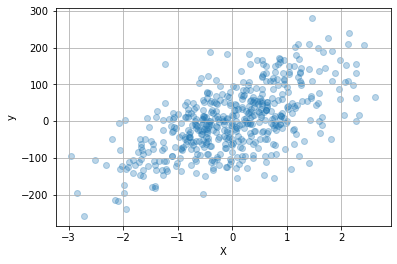

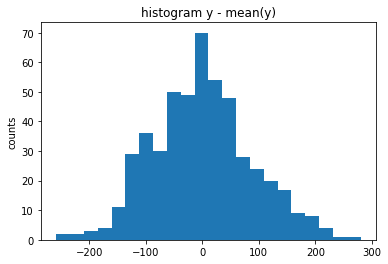

In [ ]:
import matplotlib.pyplot as plt

if n_features == 1:
    plt.scatter(X, y, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.grid(True)
    
plt.figure()
plt.hist(y - np.mean(y), bins=int(np.sqrt(len(y))))
plt.title('histogram y - mean(y)')
plt.ylabel('counts')

## Model

Similarly to the LAD regression example, suppose we have a finite dataset consisting of $n$ points $\{({X}^{(i)}, y^{(i)})\}_{i=1,\dots,n}$ with ${X}^{(i)} \in \mathbb R^k$ and $y^{(i)} \in \mathbb R$. We want to fit a linear model with intercept, whose error or deviation term $e_i$ is equal to

$$
    e_i = y^{(i)} - {m}^\top {X}^{(i)} - b = y^{(i)} - \sum_{j=1}^k X^{(i)}_j m_j - b,
$$

for some real numbers $b, m_1,\dots,m_k$. The Ordinary Least Squares (OLS) is a possible statistical optimality criterion for such a linear regression, which tries to minimize the sum of the errors squares, that is $\sum_{i=1}^n e_i^2$. The OLS regression can thus be formulated as an optimization with the coefficients $b$ and $m_i$'s and the errors $e_i$'s as the decision variables, namely

$$
\begin{align}
    \min \quad & \sum_{i=1}^n e_i^2\\
    \text{s.t.} \quad & e_i = y^{(i)} - {m}^\top {X}^{(i)} - b, \qquad \forall\, i=1,\dots,n.
\end{align}
$$

In [ ]:
import pyomo.environ as pyo

def ols_regression(X, y):

    m = pyo.ConcreteModel('OLS Regression')

    n, k = X.shape

    # note use of Python style zero based indexing 
    m.I = pyo.RangeSet(0, n-1)
    m.J = pyo.RangeSet(0, k-1)

    m.e = pyo.Var(m.I, domain=pyo.Reals)
    m.m = pyo.Var(m.J)
    m.b = pyo.Var()

    @m.Constraint(m.I)
    def residuals(m, i):
        return m.e[i] == y[i] - sum(X[i][j]*m.m[j] for j in m.J) - m.b

    @m.Objective(sense=pyo.minimize)
    def sum_of_abs_errors(m):
        return sum((m.e[i])**2 for i in m.I)

    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = ols_regression(X, y)
m.m.display()
m.b.display()

m : Size=1, Index=J
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      0 :  None : 53.49847313217242 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value            : Upper : Fixed : Stale : Domain
    None :  None : 0.42809468044769 :  None : False : False :  Reals


## Convexity

Denote by ${\theta}=(b,{m}) \in \mathbb{R}^{k+1}$ the vector comprising all variables, by $y =(y^{(1)}, \dots, y^{(n)})$, and by ${\tilde{X}} = \mathbb{R}^{d \times (n+1)}$ the so-called *design matrix* associated with the dataset, that is

$$
    {\tilde{X}} = \left[
    \begin{array}{cccc}
    {1} & {X}^{(1)} & \dots & {X}^{(n)}
    \end{array}\right].
$$

We can then rewrite the minimization problem above as an unconstrained optimization problem in the vector of variables ${\theta}$, namely

$$
    \min_{{\theta}} f({\theta}),
$$

with $f: \mathbb{R}^{k+1} \rightarrow \mathbb{R}$ defined as $f({\theta}):=\| {y} - {\tilde{X}} {\theta} \|_2^2$. Note that here $y$ and ${X}^{(i)}$, $i=1,\dots,n$ are not a vector of variables, but rather of know parameters. The Hessian of the objective function can be calculated to be

$$
    \nabla^2 f(\theta) = 2 {\tilde{X}}^\top {\tilde{X}}.
$$

In particular, it is a constant matrix that does not depend on the variables ${\theta}$ and it is always positive semi-definite, since

$$
    t^\top \nabla^2 f(\theta) t = 2 t^\top {\tilde{X}}^\top \tilde{X} t = 2 \| {\tilde{X}} t \|_2^2 \geq 0, \qquad \forall \, t \in \mathbb{R}^{k+1}.
$$

The OLS optimization problem is then always convex.

## Visualizing the results and comparison with LAD regression

In [46]:
def lad_regression(X, y):

    m = pyo.ConcreteModel('LAD Regression')

    n, k = X.shape

    # note use of Python style zero based indexing 
    m.I = pyo.RangeSet(0, n-1)
    m.J = pyo.RangeSet(0, k-1)

    m.ep = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.em = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.m = pyo.Var(m.J)
    m.b = pyo.Var()

    @m.Constraint(m.I)
    def residuals(m, i):
        return m.ep[i] - m.em[i] == y[i] - sum(X[i][j]*m.m[j] for j in m.J) - m.b

    @m.Objective(sense=pyo.minimize)
    def sum_of_abs_errors(m):
        return sum(m.ep[i] + m.em[i] for i in m.I)

    pyo.SolverFactory('glpk').solve(m)
    
    return m

m2 = lad_regression(X, y)
m2.m.display()
m2.b.display()

m : Size=1, Index=J
    Key : Lower : Value            : Upper : Fixed : Stale : Domain
      0 :  None : 51.4285764006137 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :  None : -1.41302681250894 :  None : False : False :  Reals


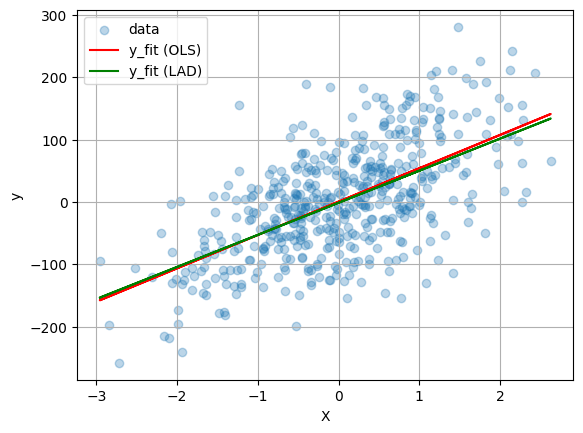

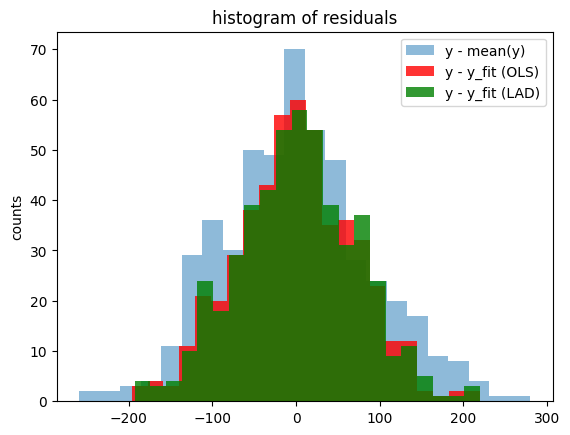

In [47]:
y_fit = np.array([sum(x[j]*m.m[j]() for j in m.J) + m.b() for x in X])
y_fit2 = np.array([sum(x[j]*m2.m[j]() for j in m2.J) + m2.b() for x in X])

if n_features == 1:
    plt.scatter(X, y, alpha=0.3, label="data")
    plt.plot(X, y_fit, 'r', label="y_fit (OLS)")
    plt.plot(X, y_fit2, 'g', label="y_fit (LAD)")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    
plt.figure()
plt.hist(y - np.mean(y), bins=int(np.sqrt(len(y))), alpha=0.5, label="y - mean(y)")
plt.hist(y - y_fit, bins=int(np.sqrt(len(y))), color='r', alpha=0.8, label="y - y_fit (OLS)")
plt.hist(y - y_fit2, bins=int(np.sqrt(len(y))), color='g', alpha=0.8, label="y - y_fit (LAD)")
plt.title('histogram of residuals')
plt.ylabel('counts')
plt.legend()